<a href="https://colab.research.google.com/github/VincentAntony/FARMWISE/blob/main/FARMWISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Loading required libraries and functions
import itertools
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from keras import backend
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import decode_predictions, preprocess_input

In [2]:
from google.colab import drive
import os

drive.mount ('/content/drive/')

Mounted at /content/drive/


In [3]:
base_dir = '/content/drive/My Drive/PPL ADPL'
! ls "/content/drive/My Drive/PPL ADPL"
categories = os.listdir(base_dir)
num_class = len(categories)

Test  Train  Valid


In [4]:
#menentukan direktori
train_dir = os.path.join(base_dir,'Train')
test_dir = os.path.join(base_dir,'Test')
validation_dir = os.path.join(base_dir,'Valid')

In [5]:
#menentukan direktori isi bahan
A_dir = os.path.join(train_dir, 'healthycow/')
B_dir = os.path.join(train_dir, 'lumpycow/')

print ("Jumlah Data Train Tiap Kelas")
print ('Jumlah  data healthycow :',len(os.listdir(A_dir)))
print ('Jumlah data lumpy:', len(os.listdir(B_dir)))

Jumlah Data Train Tiap Kelas
Jumlah  data healthycow : 1439
Jumlah data lumpy: 990


In [6]:
# Direketori isi latih/training
test_A = os.path.join(test_dir, 'healthycow/')
test_B = os.path.join(test_dir, 'lumpycow/')

#Direktori isi validasi
validation_A = os.path.join(validation_dir, 'healthycow/')
validation_B = os.path.join(validation_dir, 'lumpycow/')


In [7]:
print ('Jumlah data train healty:', len(os.listdir(A_dir)))
print ('Jumlah All Test healty :', len(os.listdir(test_B)))
print ('Jumlah All Val healty:', len(os.listdir(validation_A)))

print ('Jumlah All train lumpy :', len(os.listdir(B_dir)))
print ('Jumlah All Test lumpy :', len(os.listdir(test_B)))
print ('Jumlah All Val lumpy :', len(os.listdir(validation_B)))

Jumlah data train healty: 1439
Jumlah All Test healty : 775
Jumlah All Val healty: 377
Jumlah All train lumpy : 990
Jumlah All Test lumpy : 775
Jumlah All Val lumpy : 282


In [10]:
train_datagen = ImageDataGenerator(
                rescale = 1./225,
                rotation_range =30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range =0.1
)

val_datagen = ImageDataGenerator(
               rescale = 1./225,
                rotation_range =30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range =0.1
)


In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size =20,
    class_mode = 'categorical'
)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (224,224),
    batch_size =20,
    class_mode = 'categorical'
)


Found 2429 images belonging to 2 classes.
Found 659 images belonging to 2 classes.


In [12]:
import os

class_names = sorted(os.listdir(train_dir))
class_names


['healthycow', 'lumpycow']

(337, 150)


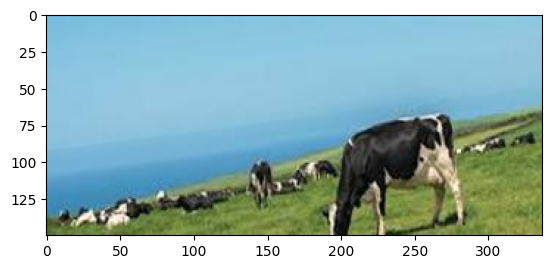

In [13]:
from keras.preprocessing.image import load_img
import random
import matplotlib.pyplot as plt
import tensorflow as tf

filenames = os.listdir(f'{train_dir}/healthycow')
sample = random.choice(filenames)
image = load_img(f'{train_dir}/healthycow/'+sample)
plt.imshow(image)
print(image.size)

In [14]:
from glob import glob
from PIL import Image

def show_random_images_from(glob_path, seed=None):
    if seed:
        random.seed(seed)
    file_names = glob(glob_path)
    file_names_sample = random.sample(file_names, min(len(file_names), 8))
    fig, axes = plt.subplots(2, 4, figsize=(12, 8), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})
    axes = axes.flatten()
    for i, (ax, file_path) in enumerate(zip(axes, file_names_sample)):
        img = Image.open(file_path)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

<ipython-input-14-7df70479d1f3>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


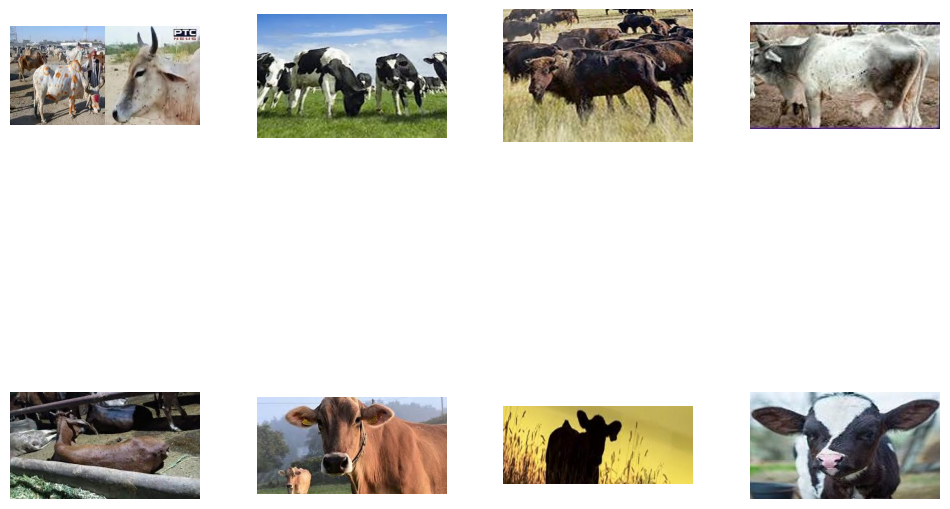

In [15]:
show_random_images_from(f"{train_dir}/*/*", seed=120)

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Model

vgg_base = VGG16(weights="imagenet",
                 include_top=False,
                 input_shape=(224, 224, 3))

for layer in vgg_base.layers:
    layer.trainable = False

model = Sequential()

model.add(vgg_base)

model.add(Flatten())

model.add(Dense(2, activation="softmax"))


58889256/58889256 [==============================] - 3s 0us/step


In [17]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14764866 (56.32 MB)
Trainable params: 50178 (196.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [18]:
# Compile the model
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


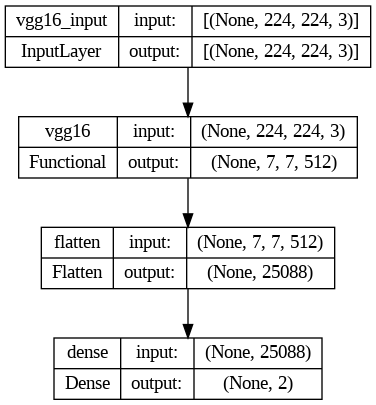

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
history = model.fit(
          train_generator,
          epochs =15,
          validation_data= val_generator,
          validation_steps= 1,
          verbose = 1,
)

Epoch 1/15
122/122 [==============================] - 1647s 13s/step - loss: 0.5983 - accuracy: 0.7291 - val_loss: 0.6544 - val_accuracy: 0.7000
Epoch 2/15
122/122 [==============================] - 1571s 13s/step - loss: 0.4954 - accuracy: 0.8028 - val_loss: 0.3849 - val_accuracy: 0.7500
Epoch 3/15
122/122 [==============================] - 1567s 13s/step - loss: 0.4616 - accuracy: 0.8135 - val_loss: 0.2318 - val_accuracy: 0.8500
Epoch 4/15
122/122 [==============================] - 1564s 13s/step - loss: 0.4361 - accuracy: 0.8176 - val_loss: 0.3806 - val_accuracy: 0.8500
Epoch 5/15
122/122 [==============================] - 1550s 13s/step - loss: 0.4042 - accuracy: 0.8349 - val_loss: 0.6126 - val_accuracy: 0.6000
Epoch 6/15
122/122 [==============================] - 1562s 13s/step - loss: 0.4408 - accuracy: 0.8259 - val_loss: 0.3594 - val_accuracy: 0.8000
Epoch 7/15
122/122 [==============================] - 1567s 13s/step - loss: 0.4282 - accuracy: 0.8357 - val_loss: 0.5456 - val_ac

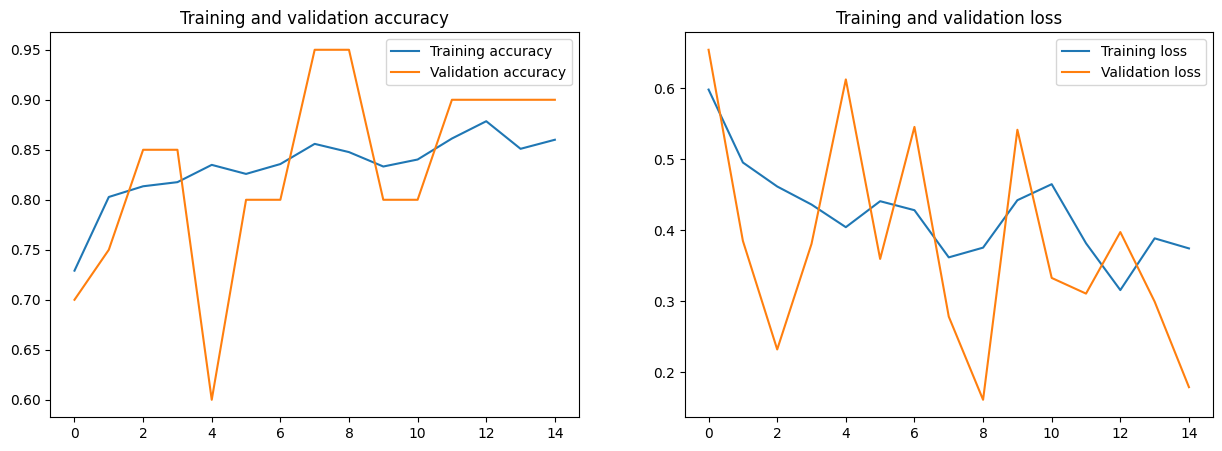

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.plot(epochs, acc, label='Training accuracy')
ax1.plot(epochs, val_acc, label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(loc=0)


ax2.plot(epochs, loss, label='Training loss')
ax2.plot(epochs, val_loss, label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(loc=0)

Saving img2139.jpg to img2139.jpg
1/1 [==============================] - 1s 541ms/step
The image is classified as [0. 1.]
Prediction for the image below: lumpycow


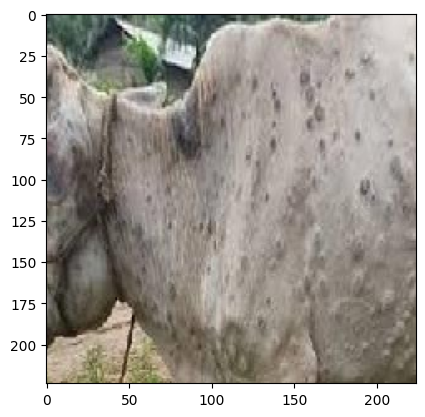

In [24]:
import keras
from keras.preprocessing import image
from google.colab import files
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():

  # Predicting Images
  path = fn
  img = keras.preprocessing.image.load_img(path, target_size=(224, 224,3))
  x = keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  plt.imshow(img)
  img = np.expand_dims(img, axis = 0)
  predictions = model.predict(img)
  print("The image is classified as", predictions[0])
  predicted_class = class_names[np.argmax(predictions[0])]
  print("Prediction for the image below:", predicted_class)